# Multi-Objective Genetic Tuning of Forecast Model for Tech Stock Trading: Balancing Accuracy and Profitability for Informed Decision-Making

This notebook performs a complete pipeline for initial preparing financial time-series data for multi-objective optimization using ARIMA-GARCH and LSTM models. 

## Inital Data Downloading and Adjustment

### Download Data

In [1]:
import yfinance as yf
import pandas as pd
import os

tickers = ['AAPL', 'MSFT', 'AMZN', 'META', 'NVDA', 'GOOGL', 'TSLA']
start_date = '2010-01-01'
end_date = '2020-12-31'

if not os.path.exists('data/raw'):
    os.makedirs('data/raw')

for ticker in tickers:
    try:
        data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False, progress=False)
        if data.empty:
            print(f"Warning: No data found for {ticker} in the specified range.")
            continue 
        file_path = f"data/raw/{ticker}_data.csv"
        data.to_csv(file_path)
        print(f"Saved {ticker} data to {file_path}.")
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")

print(f"\nAll downloads complete.")

Saved AAPL data to data/raw/AAPL_data.csv.
Saved MSFT data to data/raw/MSFT_data.csv.
Saved AMZN data to data/raw/AMZN_data.csv.
Saved META data to data/raw/META_data.csv.
Saved NVDA data to data/raw/NVDA_data.csv.
Saved GOOGL data to data/raw/GOOGL_data.csv.
Saved TSLA data to data/raw/TSLA_data.csv.

All downloads complete.


### Data Adjustment & Combination

In [2]:
os.makedirs('data/combined', exist_ok=True)
os.makedirs('data/transformed', exist_ok=True)
os.makedirs('data/cleaned', exist_ok=True)

df_adjusted_list = []

for ticker in tickers:
    # --- Data Adjustment Part ---
    df_raw = pd.read_csv(f"data/raw/{ticker}_data.csv", skiprows=3, header=None)
    df_raw.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close','Volume'] 
    df_raw.insert(0, 'Ticker', ticker)
    df_raw['Date'] = pd.to_datetime(df_raw['Date']) 
    df_raw.to_csv(f"data/raw/{ticker}_adjusted.csv", index=False)
    df_adjusted_list.append(df_raw)

# --- Data Combination Part ---
df_combined = pd.concat(df_adjusted_list, ignore_index=True)
df_combined.to_csv('data/combined/combined_data.csv', index=False)

# --- Verification ---
df_combined = df_combined.sort_values(by=['Ticker', 'Date']).reset_index(drop=True)
print(df_combined.head(10))

  Ticker       Date      Open      High       Low     Close  Adj Close  \
0   AAPL 2010-01-04  6.424606  7.643214  7.660714  7.585000   7.622500   
1   AAPL 2010-01-05  6.435713  7.656429  7.699643  7.616071   7.664286   
2   AAPL 2010-01-06  6.333344  7.534643  7.686786  7.526786   7.656429   
3   AAPL 2010-01-07  6.321635  7.520714  7.571429  7.466071   7.562500   
4   AAPL 2010-01-08  6.363663  7.570714  7.571429  7.466429   7.510714   
5   AAPL 2010-01-11  6.307526  7.503929  7.607143  7.444643   7.600000   
6   AAPL 2010-01-12  6.235779  7.418571  7.491786  7.372143   7.471071   
7   AAPL 2010-01-13  6.323736  7.523214  7.533214  7.289286   7.423929   
8   AAPL 2010-01-14  6.287112  7.479643  7.516429  7.465000   7.503929   
9   AAPL 2010-01-15  6.182041  7.354643  7.557143  7.352500   7.533214   

      Volume  
0  493729600  
1  601904800  
2  552160000  
3  477131200  
4  447610800  
5  462229600  
6  594459600  
7  605892000  
8  432894000  
9  594067600  


### NasDaq Calendar Alignment


In [3]:
def perform_calendar_alignment(df_combined_input, all_tickers_list, output_path):
    """
    Performs calendar alignment for all stock tickers to ensure each ticker
    has a row for every unique trading day in the dataset.

    Args:
        df_combined_input (pd.DataFrame): DataFrame containing combined data of all tickers.
                                        Must contain 'Ticker' and 'Date' columns.
        all_tickers_list (list): List of all stock tickers that need calendar alignment.
        output_path (str): The file path to save the calendar-aligned DataFrame.

    Returns:
        pd.DataFrame: The DataFrame after calendar alignment, with NaNs filled for missing dates.
    """
    if not pd.api.types.is_datetime64_any_dtype(df_combined_input['Date']):
        df_combined_input['Date'] = pd.to_datetime(df_combined_input['Date'])

    all_unique_dates_from_combined = sorted(df_combined_input['Date'].unique().tolist())
    print(f"Total unique trading days identified from combined data: {len(all_unique_dates_from_combined)}")

    full_calendar_df = pd.DataFrame(
    [(ticker, date) for ticker in tickers for date in all_unique_dates_from_combined],
    columns=['Ticker', 'Date']
)
    df_aligned = pd.merge(full_calendar_df, df_combined_input, on =['Ticker', 'Date'], how='left')

    print("\n--- DataFrame Head After Calendar Alignment (showing introduced NaNs) ---")
    print(df_aligned.head(10))
    print(f"\nNumber of NaNs after calendar alignment: {df_aligned.isnull().sum().sum()}")

    output_dir = os.path.dirname(output_path)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    df_aligned.to_csv(output_path, index=False)
    print(f"Calendar aligned data saved to {output_path}")

    return df_aligned

In [4]:
df_combined = pd.read_csv('data/combined/combined_data.csv')
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'TSLA']

df_aligned = perform_calendar_alignment(df_combined, tickers, 'data/cleaned/data_aligned_with_calendar.csv')

Total unique trading days identified from combined data: 2768

--- DataFrame Head After Calendar Alignment (showing introduced NaNs) ---
  Ticker       Date      Open      High       Low     Close  Adj Close  \
0   AAPL 2010-01-04  6.424606  7.643214  7.660714  7.585000   7.622500   
1   AAPL 2010-01-05  6.435713  7.656429  7.699643  7.616071   7.664286   
2   AAPL 2010-01-06  6.333344  7.534643  7.686786  7.526786   7.656429   
3   AAPL 2010-01-07  6.321635  7.520714  7.571429  7.466071   7.562500   
4   AAPL 2010-01-08  6.363663  7.570714  7.571429  7.466429   7.510714   
5   AAPL 2010-01-11  6.307526  7.503929  7.607143  7.444643   7.600000   
6   AAPL 2010-01-12  6.235779  7.418571  7.491786  7.372143   7.471071   
7   AAPL 2010-01-13  6.323736  7.523214  7.533214  7.289286   7.423929   
8   AAPL 2010-01-14  6.287112  7.479643  7.516429  7.465000   7.503929   
9   AAPL 2010-01-15  6.182041  7.354643  7.557143  7.352500   7.533214   

        Volume  
0  493729600.0  
1  601904800.0

### Data Overview

In [5]:
df_aligned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19376 entries, 0 to 19375
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Ticker     19376 non-null  object        
 1   Date       19376 non-null  datetime64[ns]
 2   Open       18655 non-null  float64       
 3   High       18655 non-null  float64       
 4   Low        18655 non-null  float64       
 5   Close      18655 non-null  float64       
 6   Adj Close  18655 non-null  float64       
 7   Volume     18655 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 1.2+ MB


In [6]:
df_aligned.describe()

,Date,Open,High,Low,Close,Adj Close,Volume
count,19376,18655.000000,18655.000000,18655.000000,18655.000000,18655.000000,1.865500e+04
mean,2015-07-02 21:51:30.173410304,43.180353,44.639497,45.128964,44.100067,44.626817,1.658352e+08
min,2010-01-04 00:00:00,0.203560,0.222000,0.226250,0.216250,0.218000,1.777500e+06
25%,2012-09-30 06:00:00,11.599809,12.187437,12.335607,12.032381,12.191971,3.483650e+07
50%,2015-07-04 00:00:00,22.909273,26.174423,26.480000,25.910000,26.190001,7.592400e+07
75%,2018-04-03 06:00:00,54.672983,56.515249,57.066500,55.875250,56.484999,1.880270e+08
max,2020-12-30 00:00:00,302.251831,303.910004,304.670013,293.049988,300.160004,3.692928e+09
std,NaN,50.924003,51.543086,52.137724,50.871687,51.518128,2.347153e+08


In [7]:
df_aligned.isnull().sum()

Ticker         0
Date           0
Open         721
High         721
Low          721
Close        721
Adj Close    721
Volume       721
dtype: int64

## Data Cleaning and Preparation

### Handle missing values

In [8]:
def handle_nans_safely(df_aligned_input, ipo_dates_map, output_path):
    """
    Handles NaN values after calendar alignment, including filtering data before IPO,
    filling NaNs for prices (ffill) and volume (fillna(0)), and dropping any remaining rows with NaNs.

    Args:
        df_aligned_input (pd.DataFrame): The DataFrame that has undergone calendar alignment and contains NaNs.
        ipo_dates_map (dict): A dictionary containing the IPO date for each stock ticker.
        output_path (str): The file path to save the final cleaned DataFrame.

    Returns:
        pd.DataFrame: The cleaned DataFrame, ready for Feature Engineering.
    """
    df_aligned_input['Date'] = pd.to_datetime(df_aligned_input['Date'])
    df_aligned_input.sort_values(by=['Ticker', 'Date'], inplace=True)

    price_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close']
    df_ipo_processed = pd.DataFrame()

    for ticker in df_aligned_input['Ticker'].unique():
        ticker_data = df_aligned_input[df_aligned_input['Ticker'] == ticker].copy()

        current_ipo_date = ipo_dates_map.get(ticker, pd.to_datetime('1900-01-01'))

        ticker_data_filtered = ticker_data[ticker_data['Date'] >= current_ipo_date].copy()

        for col in price_cols:
            ticker_data_filtered[col] = ticker_data_filtered[col].ffill()

        ticker_data_filtered['Volume'] = ticker_data_filtered['Volume'].fillna(0)
        ticker_data_filtered['Volume'] = pd.to_numeric(ticker_data_filtered['Volume'], downcast='integer')

        initial_rows = len(ticker_data_filtered)
        ticker_data_filtered.dropna(inplace=True)
        if len(ticker_data_filtered) < initial_rows:
            print(f"  Removed {initial_rows - len(ticker_data_filtered)} rows with remaining NaNs for {ticker} after ffill/fillna.")

        df_ipo_processed = pd.concat([df_ipo_processed, ticker_data_filtered])

  
    df_ipo_processed.sort_values(by=['Ticker', 'Date'], inplace=True)

    print(f"\nNumber of NaNs after final cleaning: {df_ipo_processed.isnull().sum().sum()}")


    output_dir = os.path.dirname(output_path)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    df_ipo_processed.to_csv(output_path, index=False)
    print(f"Final cleaned data saved to {output_path}")

    return df_ipo_processed

In [9]:
ipo_dates = {
    'AAPL': pd.to_datetime('1980-12-12'),
    'NVDA': pd.to_datetime('1999-01-22'),
    'META': pd.to_datetime('2012-05-18'), 
    'GOOGL': pd.to_datetime('2004-08-19'),
    'MSFT': pd.to_datetime('1986-03-13'),
    'AMZN': pd.to_datetime('1997-05-15'),
    'TSLA': pd.to_datetime('2010-06-29')
}

df_ipo_processed = handle_nans_safely(df_aligned, ipo_dates, 'data/cleaned/data_initial_cleaned_for_all_models.csv')


Number of NaNs after final cleaning: 0
Final cleaned data saved to data/cleaned/data_initial_cleaned_for_all_models.csv


/Users/duybui/Documents/Hieu-Han-Github/Personal-Project-/tech-stock-forecasting/venv/lib/python3.12/site-packages/pandas/core/dtypes/cast.py:377: RuntimeWarning: invalid value encountered in cast
  new_result = trans(result).astype(dtype)


### Remove Duplicates

In [10]:
initial_rows_before_dupe_drop = len(df_ipo_processed)
df_ipo_processed.drop_duplicates(subset=['Ticker', 'Date'], inplace=True)
print(f"Removed {initial_rows_before_dupe_drop - len(df_ipo_processed)} duplicate rows.")

Removed 0 duplicate rows.


### Handle Outliers

In [11]:
df_outlier_treated = df_ipo_processed.copy()
cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

for col in cols:
    rolling_mean = df_outlier_treated.groupby('Ticker')[col].transform(lambda x: x.rolling(window=30, min_periods=1).mean())
    rolling_std = df_outlier_treated.groupby('Ticker')[col].transform(lambda x: x.rolling(window=30, min_periods=1).std())

    # Build the outlier mask for the current column using these transformed series
    # These conditions now apply to the entire 'col' series, compared against the ticker-specific rolling stats
    cond_high_outlier = (df_outlier_treated[col] > rolling_mean + 8 * rolling_std)
    cond_low_outlier = (df_outlier_treated[col] < rolling_mean - 8 * rolling_std)
    # Condition for values below $1, applied across the whole column
    cond_below_one = (df_outlier_treated[col] < 1)

    # Combine conditions. .fillna(False) handles NaNs from rolling window initial periods.
    outlier_mask_for_col = (cond_high_outlier | cond_low_outlier | cond_below_one).fillna(False)

    # Instead of just making, we'll immediately fill the masked NaNs with rolling mean
    df_outlier_treated[col] = df_outlier_treated[col].mask(outlier_mask_for_col, rolling_mean)


# Assign df_outloer_treated to df_cleaned_for_features
df_final_cleaned = df_outlier_treated.copy()
print(f"NaNs after outlier flagging and imputation: {df_final_cleaned.isnull().sum().sum()}")
print("DataFrame head after initial cleaning (outliers imputed):")
print(df_final_cleaned.head())

# Save the initially cleaned data (after initial NaN, duplicates, outliers) to `data/cleaned`
df_final_cleaned.to_csv('data/cleaned/data_final_cleaned_for_all_models.csv', index=False)

NaNs after outlier flagging and imputation: 0
DataFrame head after initial cleaning (outliers imputed):
  Ticker       Date      Open      High       Low     Close  Adj Close  \
0   AAPL 2010-01-04  6.424606  7.643214  7.660714  7.585000   7.622500   
1   AAPL 2010-01-05  6.435713  7.656429  7.699643  7.616071   7.664286   
2   AAPL 2010-01-06  6.333344  7.534643  7.686786  7.526786   7.656429   
3   AAPL 2010-01-07  6.321635  7.520714  7.571429  7.466071   7.562500   
4   AAPL 2010-01-08  6.363663  7.570714  7.571429  7.466429   7.510714   

      Volume  
0  493729600  
1  601904800  
2  552160000  
3  477131200  
4  447610800  


## Data Transformation

In [12]:
from statsmodels.tsa.stattools import adfuller
import numpy as np

def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print(f"ADF Statistic: {result[0]:.4f}, p-value: {result[1]:.4f}")
    return result[1] < 0.05 

def perform_basic_transformations(df_input, drop_non_stationary=False):
    df_with_basic_transforms = df_input.copy()
    df_with_basic_transforms.sort_values(by=['Ticker', 'Date'], inplace=True)

    print("[INFO] Performing basic transformations (e.g., Log Returns)...")
    df_with_basic_transforms['Log_Returns'] = df_with_basic_transforms.groupby('Ticker')['Close'].transform(
        lambda x: np.log(x / x.shift(1)))

    initial_rows_before_log_returns = len(df_with_basic_transforms)
    df_with_basic_transforms.dropna(subset=['Log_Returns'], inplace=True)
    if len(df_with_basic_transforms) < initial_rows_before_log_returns:
        print(f"  Removed {initial_rows_before_log_returns - len(df_with_basic_transforms)} rows with NaNs after Log_Returns calculation.")

    print("[INFO] Running ADF test for each Ticker...")
    stationarity_results = {}
    for ticker, group in df_with_basic_transforms.groupby('Ticker'):
        is_stationary = adf_test(group['Log_Returns'])
        stationarity_results[ticker] = is_stationary
        print(f"  {ticker} is {'stationary' if is_stationary else 'non-stationary'}.")

    if drop_non_stationary:
        stationary_tickers = [t for t, ok in stationarity_results.items() if ok]
        df_with_basic_transforms = df_with_basic_transforms[df_with_basic_transforms['Ticker'].isin(stationary_tickers)]
        print(f"[INFO] Filtered {len(stationary_tickers)} stationary tickers.")

    return df_with_basic_transforms

In [13]:
df_with_basic_transforms = perform_basic_transformations(df_final_cleaned, drop_non_stationary=True)
df_with_basic_transforms.to_csv('data/transformed/data_with_basic_transforms.csv', index=False) 

[INFO] Performing basic transformations (e.g., Log Returns)...
  Removed 7 rows with NaNs after Log_Returns calculation.
[INFO] Running ADF test for each Ticker...
ADF Statistic: -14.1633, p-value: 0.0000
  AAPL is stationary.
ADF Statistic: -31.2477, p-value: 0.0000
  AMZN is stationary.
ADF Statistic: -47.6557, p-value: 0.0000
  GOOGL is stationary.
ADF Statistic: -44.0072, p-value: 0.0000
  META is stationary.
ADF Statistic: -21.2269, p-value: 0.0000
  MSFT is stationary.
ADF Statistic: -10.4160, p-value: 0.0000
  NVDA is stationary.
ADF Statistic: -49.2755, p-value: 0.0000
  TSLA is stationary.
[INFO] Filtered 7 stationary tickers.


--- Skewness Check Before Transformation ---
Skewness of 'Open': 1.9374
Skewness of 'High': 1.9008
Skewness of 'Low': 1.9057
Skewness of 'Close': 1.8952
Skewness of 'Adj Close': 1.9004
Skewness of 'Volume': 3.6173


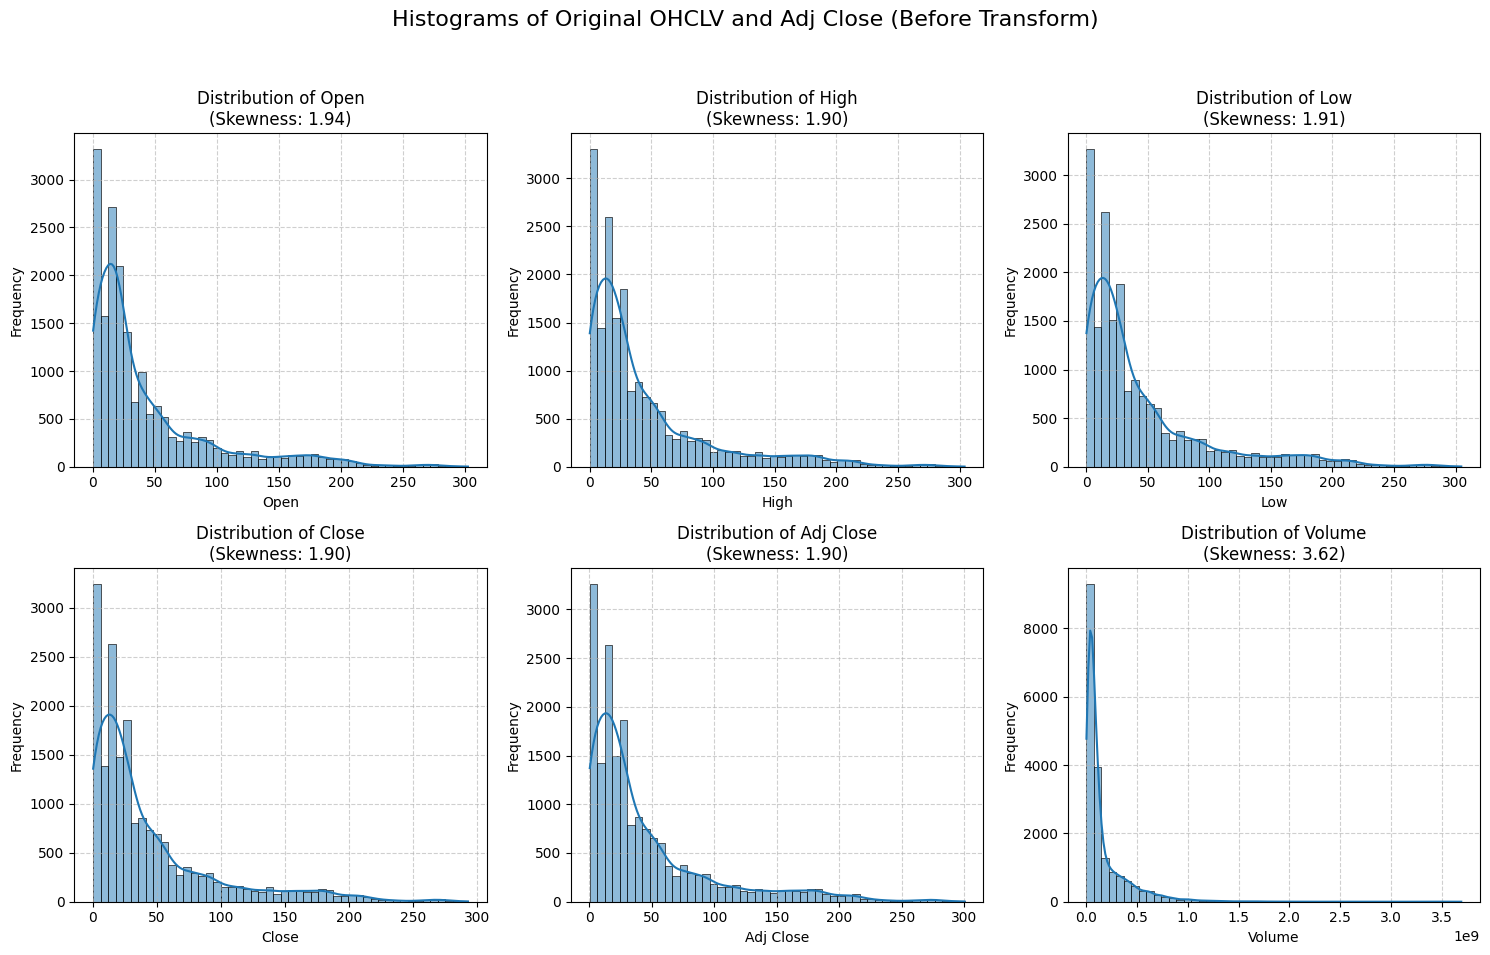

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

# --- Skewness Check and Visualization BEFORE Transformation (using subplots) ---
print("--- Skewness Check Before Transformation ---")
plt.figure(figsize=(15, 10))
plt.suptitle('Histograms of Original OHCLV and Adj Close (Before Transform)', fontsize=16)

for idx, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 3, idx) 
    skewness = df_final_cleaned[col].skew()
    print(f"Skewness of '{col}': {skewness:.4f}")

    sns.histplot(df_final_cleaned[col], kde=True, bins=50)
    plt.title(f'Distribution of {col}\n(Skewness: {skewness:.2f})') 
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.show()


--- Applying Combined Box-Cox (for Prices) and Yeo-Johnson (for Volume) Transformation ---
  Applying Box-Cox to 'Open'.
    Optimal lambda for 'Open': 0.2383
  Applying Box-Cox to 'High'.
    Optimal lambda for 'High': 0.2481
  Applying Box-Cox to 'Low'.
    Optimal lambda for 'Low': 0.2479
  Applying Box-Cox to 'Close'.
    Optimal lambda for 'Close': 0.2486
  Applying Box-Cox to 'Adj Close'.
    Optimal lambda for 'Adj Close': 0.2482
  Applying Yeo-Johnson to 'Volume'.

--- Skewness Check After Combined Transformation ---
Skewness of 'Transformed_Open': -0.0599
Skewness of 'Transformed_High': -0.0680
Skewness of 'Transformed_Low': -0.0672
Skewness of 'Transformed_Close': -0.0690
Skewness of 'Transformed_Adj Close': -0.0681
Skewness of 'Transformed_Volume': 0.0272


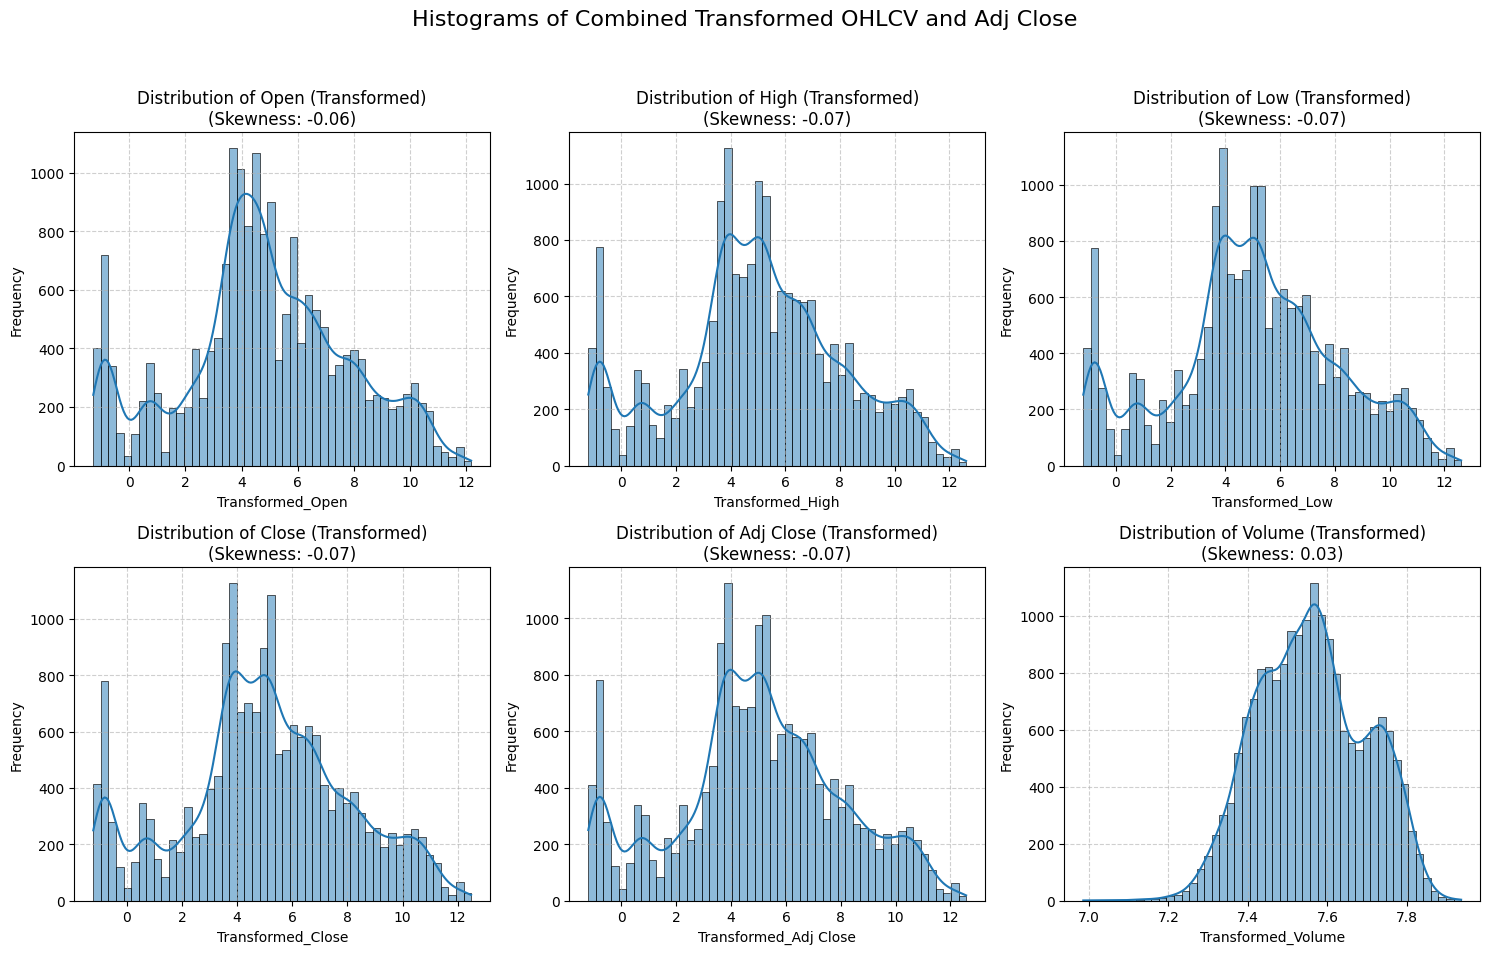

In [15]:
import numpy as np
from scipy import stats 
from sklearn.preprocessing import PowerTransformer 

df_for_feature_engineering_base = df_with_basic_transforms.copy()

print("\n--- Applying Combined Box-Cox (for Prices) and Yeo-Johnson (for Volume) Transformation ---")
for col in numeric_cols:
    if col == 'Volume':
        print(f"  Applying Yeo-Johnson to '{col}'.")
        pt = PowerTransformer(method='yeo-johnson', standardize=False) 
        df_for_feature_engineering_base[f'Transformed_{col}'] = pt.fit_transform(df_for_feature_engineering_base[[col]])

    else:
        print(f"  Applying Box-Cox to '{col}'.")

        try:
            transformed_data, optimal_lambda = stats.boxcox(df_for_feature_engineering_base[col])
            df_for_feature_engineering_base[f'Transformed_{col}'] = transformed_data
            print(f"    Optimal lambda for '{col}': {optimal_lambda:.4f}")

        except ValueError as e:
            print(f"  Error applying Box-Cox to '{col}': {e}. Falling back to np.log1p for this column.")
            df_for_feature_engineering_base[f'Transformed_{col}'] = np.log1p(df_for_feature_engineering_base[col])

print("\n--- Skewness Check After Combined Transformation ---")
plt.figure(figsize=(15, 10))
plt.suptitle('Histograms of Combined Transformed OHLCV and Adj Close', fontsize=16)

transformed_numeric_cols = [f'Transformed_{c}' for c in numeric_cols]

for idx, col_name in enumerate(transformed_numeric_cols, 1):
    plt.subplot(2, 3, idx) 

    if col_name in df_for_feature_engineering_base.columns:
        skewness_transformed = df_for_feature_engineering_base[col_name].skew()
        print(f"Skewness of '{col_name}': {skewness_transformed:.4f}")

        sns.histplot(df_for_feature_engineering_base[col_name], kde=True, bins=50)
        original_col = col_name.replace('Transformed_', '')
        plt.title(f'Distribution of {original_col} (Transformed)\n(Skewness: {skewness_transformed:.2f})')
        plt.xlabel(col_name)
        plt.ylabel('Frequency')
        plt.grid(True, linestyle='--', alpha=0.6)
    else:
        print(f"  Skipping plot for {col_name} as it was not transformed.")

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.show()

In [16]:
print("\n--- Final Transformed DataFrame Head (after skewness transforms) ---")
print(df_for_feature_engineering_base.head())

df_for_feature_engineering_base.to_csv('data/transformed/data_final_with_basic_transforms_and_skewness_corrected.csv', index=False)


--- Final Transformed DataFrame Head (after skewness transforms) ---
  Ticker       Date      Open      High       Low     Close  Adj Close  \
1   AAPL 2010-01-05  6.435713  7.656429  7.699643  7.616071   7.664286   
2   AAPL 2010-01-06  6.333344  7.534643  7.686786  7.526786   7.656429   
3   AAPL 2010-01-07  6.321635  7.520714  7.571429  7.466071   7.562500   
4   AAPL 2010-01-08  6.363663  7.570714  7.571429  7.466429   7.510714   
5   AAPL 2010-01-11  6.307526  7.503929  7.607143  7.444643   7.600000   

      Volume  Log_Returns  Transformed_Open  Transformed_High  \
1  601904800     0.004088          2.343336          2.648333   
2  552160000    -0.011793          2.318397          2.621815   
3  477131200    -0.008099          2.315525          2.618761   
4  447610800     0.000048          2.325815          2.629702   
5  462229600    -0.002922          2.312058          2.615076   

   Transformed_Low  Transformed_Close  Transformed_Adj Close  \
1         2.656861           2

## Train-Test Split

In [17]:
df_for_feature_engineering_base['Date'] = pd.to_datetime(df_for_feature_engineering_base['Date'])
end_train_val_date = '2019-11-30'

train_val_wf_df = df_for_feature_engineering_base[df_for_feature_engineering_base['Date'] <= end_train_val_date].copy()
test_df = df_for_feature_engineering_base[df_for_feature_engineering_base['Date'] > end_train_val_date].copy()

print(f"Total rows in df_for_feature_engineering_base: {len(df_for_feature_engineering_base)}")
print(f"Number of rows in train_val_wf_df: {len(train_val_wf_df)}")
print(f"Start date of train_val_wf_df: {train_val_wf_df['Date'].min()}")
print(f"End date of of train_val_wf_df: {train_val_wf_df['Date'].max()}")
print(f"Number of rows in test_df: {len(test_df)}")
print(f"Start date of test_df: {test_df['Date'].min()}")
print(f"End date of test_df: {test_df['Date'].max()}")

if len(train_val_wf_df) + len(test_df) == len(df_for_feature_engineering_base):
    print("\nSuccessully splitting!")
else:
    print("\nWarning: Please check splitting process")

train_val_wf_df.to_csv('data/cleaned/train_val_for_wf.csv', index=False)
test_df.to_csv('data/cleaned/test_set.csv', index=False)

Total rows in df_for_feature_engineering_base: 18648
Number of rows in train_val_wf_df: 16737
Start date of train_val_wf_df: 2010-01-05 00:00:00
End date of of train_val_wf_df: 2019-11-29 00:00:00
Number of rows in test_df: 1911
Start date of test_df: 2019-12-02 00:00:00
End date of test_df: 2020-12-30 00:00:00

Successully splitting!


In [18]:
train_val_wf_df['target_log_returns'] = train_val_wf_df.groupby('Ticker')['Log_Returns'].shift(-1)
test_df['target_log_returns'] = test_df.groupby('Ticker')['Log_Returns'].shift(-1)

for q in [0.60, 0.70, 0.80]:
    threshold = train_val_wf_df['target_log_returns'].quantile(q)
    print(f"\nQuantile: {q:.2f} -> Threshold: {threshold:.4f}")

    temp_train = (train_val_wf_df['target_log_returns'] > threshold).astype(int)
    temp_test = (test_df['target_log_returns'] > threshold).astype(int)

    print("[Train Target Distribution]")
    print(temp_train.value_counts(normalize=True))

    print("[Test Target Distribution]")
    print(temp_test.value_counts(normalize=True))


Quantile: 0.60 -> Threshold: 0.0040
[Train Target Distribution]
target_log_returns
0    0.600167
1    0.399833
Name: proportion, dtype: float64
[Test Target Distribution]
target_log_returns
0    0.506541
1    0.493459
Name: proportion, dtype: float64

Quantile: 0.70 -> Threshold: 0.0071
[Train Target Distribution]
target_log_returns
0    0.700125
1    0.299875
Name: proportion, dtype: float64
[Test Target Distribution]
target_log_returns
0    0.596546
1    0.403454
Name: proportion, dtype: float64

Quantile: 0.80 -> Threshold: 0.0117
[Train Target Distribution]
target_log_returns
0    0.800084
1    0.199916
Name: proportion, dtype: float64
[Test Target Distribution]
target_log_returns
0    0.688121
1    0.311879
Name: proportion, dtype: float64


In [19]:
train_val_wf_df['target_log_returns'] = train_val_wf_df.groupby('Ticker')['Log_Returns'].shift(-1)
threshold = train_val_wf_df['target_log_returns'].quantile(0.70)
print(f"Using threshold based on 70th percentile of target_log_returns: {threshold:.4f}")

Using threshold based on 70th percentile of target_log_returns: 0.0071


In [20]:
import json

with open('data/cleaned/target_threshold.json', 'w') as f:
    json.dump({'quantile': 0.70, 'threshold': threshold}, f)

## Technical Indicators

In [21]:
def calculate_rsi(series, window):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    diff = series.diff(1)
    gain = diff.mask(diff < 0, 0)
    loss = -diff.mask(diff > 0, 0) 
    avg_gain = gain.ewm(com=window - 1, min_periods=window, adjust=False).mean()
    avg_loss = loss.ewm(com=window - 1, min_periods=window, adjust=False).mean()
    rs = np.where(avg_loss == 0, np.inf, avg_gain / avg_loss)
    rsi = 100 - (100 / (1 + rs))
    return pd.Series(rsi, index=series.index)

def calculate_ema(series, span):
    return series.ewm(span=span, adjust=False).mean()

def calculate_tema(series, span):
    ema1 = calculate_ema(series, span)
    ema2 = calculate_ema(ema1, span)
    ema3 = calculate_ema(ema2, span)

    tema = (3 * ema1) - (3 * ema2) + ema3
    return tema

In [22]:
def generate_features(df, fixed_ti_params=None):
    """
    Generates technical indicator features using fixed parameter lists, per ticker.
    Returns the processed DataFrame and a list of generated feature names.
    """
    if fixed_ti_params is None:
        fixed_ti_params = {} 

    df_features = df.copy()
    feature_names = []

    df_features['Date'] = pd.to_datetime(df_features['Date'])
    df_features = df_features.sort_values(['Ticker', 'Date']).reset_index(drop=True)

    print("[INFO] Generating technical indicators...")

    # HCL3
    if fixed_ti_params.get('hlc3', False): 
        df_features['HLC3'] = (df_features['High'] + df_features['Low'] + df_features['Close']) / 3
        feature_names.append('HLC3')
        print(f"  - Generated HLC3")

    # SMAs
    for window in fixed_ti_params.get('sma_window', []):
        col = f'SMA_{window}'
        df_features[col] = df_features.groupby('Ticker')['Close'].transform(
            lambda x: x.rolling(window=window).mean()
        )
        feature_names.append(col)
        print(f"  - Generated {col}")

    # TEMAs
    for span in fixed_ti_params.get('tema_span', []): 
        col = f'TEMA_{span}'
        df_features[col] = df_features.groupby('Ticker')['Close'].transform(
            lambda x: calculate_tema(x, span)) 
        feature_names.append(col)
        print(f"  - Generated {col}")

    # RSI
    for length in fixed_ti_params.get('rsi_length', []):
        col = f'RSI_{length}'
        df_features[col] = df_features.groupby('Ticker')['Close'].transform(
            lambda x: calculate_rsi(x, length)
        )
        feature_names.append(col)
        print(f"  - Generated {col}")

    # Bollinger Bands
    for window in fixed_ti_params.get('bollinger_window', []):
        mid_col = f'BB_Mid_{window}'
        upper_col_template = f'BB_Upper_{window}_'
        lower_col_template = f'BB_Lower_{window}_'

        middle_band = df_features.groupby('Ticker')['Close'].transform(
            lambda x: x.rolling(window=window).mean())
        std_dev = df_features.groupby('Ticker')['Close'].transform(
            lambda x: x.rolling(window=window).std())

        if mid_col not in feature_names:
            df_features[mid_col] = middle_band
            feature_names.append(mid_col)
            print(f"  - Generated {mid_col}")

        for num_std in fixed_ti_params.get('bollinger_num_std_dev', []):
            upper_col = f'{upper_col_template}{num_std}Std'
            lower_col = f'{lower_col_template}{num_std}Std'

            df_features[upper_col] = middle_band + (std_dev * num_std)
            df_features[lower_col] = middle_band - (std_dev * num_std)

            feature_names.extend([upper_col, lower_col])
            print(f"  - Generated {upper_col}, {lower_col}")

    # OBV
    if 'OBV' not in df_features.columns:
        df_features['Price_Change_Sign'] = df_features.groupby('Ticker')['Close'].transform(
            lambda x: np.sign(x.diff())
        )
        df_features['Price_Change_Sign'] = df_features['Price_Change_Sign'].fillna(0)

        df_features['OBV_Contribution'] = df_features['Price_Change_Sign'] * df_features['Volume']

        df_features['OBV'] = df_features.groupby('Ticker')['OBV_Contribution'].cumsum()

        feature_names.append('OBV')
        print(f"  - Generated OBV")

        df_features = df_features.drop(columns=['Price_Change_Sign', 'OBV_Contribution'])


    # Lagged features
    print("[INFO] Generating lagged features...")
    for lag in fixed_ti_params.get('lag_period', []):
        # Lagged main price column
        lag_col_price = f'{'Close'}_lag_{lag}'
        df_features[lag_col_price] = df_features.groupby('Ticker')['Close'].transform(lambda x: x.shift(lag))
        feature_names.append(lag_col_price)
        print(f"    - Generated {lag_col_price}")

        # Lagged HLC3 
        if 'HLC3' in df_features.columns:
            lag_hlc3_col = f'HLC3_lag_{lag}'
            df_features[lag_hlc3_col] = df_features.groupby('Ticker')['HLC3'].transform(lambda x: x.shift(lag))
            feature_names.append(lag_hlc3_col)
            print(f"    - Generated {lag_hlc3_col}")

        # Lagged RSI for each RSI length (ensure RSI column exists)
        for length in fixed_ti_params.get('rsi_length', []):
            rsi_col = f'RSI_{length}'
            if rsi_col in df_features.columns:
                lag_rsi_col = f'RSI_{length}_lag_{lag}'
                df_features[lag_rsi_col] = df_features.groupby('Ticker')[rsi_col].transform(lambda x: x.shift(lag))
                feature_names.append(lag_rsi_col)
                print(f"    - Generated {lag_rsi_col}")

        # Lagged OBV (ensure OBV column exists)
        if 'OBV' in df_features.columns:
            obv_lag_col = f'OBV_lag_{lag}'
            df_features[obv_lag_col] = df_features.groupby('Ticker')['OBV'].transform(lambda x: x.shift(lag))
            feature_names.append(obv_lag_col)
            print(f"    - Generated {obv_lag_col}")

        # Lagged Log_Returns (ensure Log_Returns column exists)
        if 'Log_Returns' in df_features.columns:
            logret_lag_col = f'Log_Returns_lag_{lag}'
            df_features[logret_lag_col] = df_features.groupby('Ticker')['Log_Returns'].transform(lambda x: x.shift(lag))
            feature_names.append(logret_lag_col)
            print(f"    - Generated {logret_lag_col}")

    feature_names = list(set(feature_names))

    print("[INFO] Feature generation complete.")
    return df_features, feature_names


In [23]:
fixed_ti_params = {
    'hcl3': True,
    'sma_window': [5],
    'tema_span': [12, 26],
    'rsi_length': [7, 14],
    'bollinger_window': [10, 20],
    'bollinger_num_std_dev': [1.5, 2],
    'lag_period': [1, 3, 5],
}

train_val_wf_df = pd.read_csv('data/cleaned/train_val_for_wf.csv')
test_df = pd.read_csv('data/cleaned/test_set.csv')

# === TRAIN SET ===
print("\n--- Generating Features for Train-Validation Set ---")
train_val_wf_df_with_features, train_features_list = generate_features(train_val_wf_df.copy(), fixed_ti_params=fixed_ti_params)
train_val_wf_df_with_features['target_log_returns'] = train_val_wf_df_with_features.groupby('Ticker')['Log_Returns'].shift(-1)
train_val_wf_df_with_features['target'] = (train_val_wf_df_with_features['target_log_returns'] > threshold).astype(int)
train_val_wf_df_with_features['Close_raw'] = train_val_wf_df_with_features['Close']

initial_rows_train_fe = len(train_val_wf_df_with_features)
train_val_wf_df_with_features.dropna(inplace=True)
if len(train_val_wf_df_with_features) < initial_rows_train_fe:
    print(f"  Removed {initial_rows_train_fe - len(train_val_wf_df_with_features)} rows with NaNs from train_val_wf_df_with_features after FE/Target generation.")

# === TEST SET ===
print("\n--- Generating Features for Test Set ---")
test_df_with_features, test_features_list = generate_features(test_df.copy(), fixed_ti_params=fixed_ti_params)
test_df_with_features['target_log_returns'] = test_df_with_features.groupby('Ticker')['Log_Returns'].shift(-1)
test_df_with_features['target'] = (test_df_with_features['target_log_returns'] > threshold).astype(int)

initial_rows_test_fe = len(test_df_with_features)
test_df_with_features.dropna(inplace=True)
if len(test_df_with_features) < initial_rows_test_fe:
    print(f"  Removed {initial_rows_test_fe - len(test_df_with_features)} rows with NaNs from test_df_with_features after FE/Target generation.")

assert set(train_features_list) == set(test_features_list), "Feature lists for train and test do not match!"

train_val_wf_df_with_features.to_csv('data/cleaned/train_val_for_wf_with_features.csv', index=False)
test_df_with_features.to_csv('data/cleaned/test_set_with_features.csv', index=False)



--- Generating Features for Train-Validation Set ---
[INFO] Generating technical indicators...
  - Generated SMA_5
  - Generated TEMA_12
  - Generated TEMA_26
  - Generated RSI_7
  - Generated RSI_14
  - Generated BB_Mid_10
  - Generated BB_Upper_10_1.5Std, BB_Lower_10_1.5Std
  - Generated BB_Upper_10_2Std, BB_Lower_10_2Std
  - Generated BB_Mid_20
  - Generated BB_Upper_20_1.5Std, BB_Lower_20_1.5Std
  - Generated BB_Upper_20_2Std, BB_Lower_20_2Std
  - Generated OBV
[INFO] Generating lagged features...
    - Generated Close_lag_1
    - Generated RSI_7_lag_1
    - Generated RSI_14_lag_1
    - Generated OBV_lag_1
    - Generated Log_Returns_lag_1
    - Generated Close_lag_3
    - Generated RSI_7_lag_3
    - Generated RSI_14_lag_3
    - Generated OBV_lag_3
    - Generated Log_Returns_lag_3
    - Generated Close_lag_5
    - Generated RSI_7_lag_5
    - Generated RSI_14_lag_5
    - Generated OBV_lag_5
    - Generated Log_Returns_lag_5
[INFO] Feature generation complete.
  Removed 140 rows wi

In [24]:
print(len(train_val_wf_df_with_features))
print(len(test_df_with_features))

16597
1771


In [25]:
print("\n[Train Target Distribution]")
print(train_val_wf_df_with_features['target'].value_counts(normalize=True))
print("\n[Test Target Distribution]")
print(test_df_with_features['target'].value_counts(normalize=True))


[Train Target Distribution]
target
0    0.699705
1    0.300295
Name: proportion, dtype: float64

[Test Target Distribution]
target
0    0.588368
1    0.411632
Name: proportion, dtype: float64


In [26]:
train_val_wf_df_with_features.head()

,Ticker,Date,Open,High,Low,Close,Adj Close,Volume,Log_Returns,Transformed_Open,...,OBV_lag_3,Log_Returns_lag_3,Close_lag_5,RSI_7_lag_5,RSI_14_lag_5,OBV_lag_5,Log_Returns_lag_5,target_log_returns,target,Close_raw
19,AAPL,2010-02-02,5.879740,6.995000,7.011429,6.906429,6.996786,698342400,0.010814,2.204044,...,-2.516458e+09,-0.004168,7.235000,37.794671,26.940207,3.796128e+08,0.011868,0.005364,0,6.906429
20,AAPL,2010-02-03,5.980907,7.115357,7.150000,6.943571,6.970357,615328000,0.005364,2.230116,...,-3.762410e+09,-0.043457,7.126071,32.639603,24.893515,-1.342956e+09,-0.015170,-0.014767,0,6.943571
21,AAPL,2010-02-04,5.765364,6.858929,7.084643,6.841786,7.026071,757652000,-0.014767,2.174153,...,-3.012534e+09,0.005504,7.096429,31.284881,24.351359,-2.516458e+09,-0.004168,-0.003766,0,6.841786
22,AAPL,2010-02-05,5.867732,6.980714,7.000000,6.816071,6.879643,850306800,-0.003766,2.200927,...,-2.314192e+09,0.010814,6.794643,20.954454,19.657404,-3.762410e+09,-0.043457,0.016370,1,6.816071
23,AAPL,2010-02-08,5.827505,6.932857,7.067143,6.928571,6.988929,478270800,0.016370,2.190449,...,-1.698864e+09,0.005364,6.832143,24.565490,21.677709,-3.012534e+09,0.005504,0.003859,0,6.928571
